In [0]:

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

# two classes
# 1) DeepQ Network, handle forward propogation operation
# 2) Agent that will hold object for DeepQ network and memory func to choose action and learning

class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims,fc2_dims,n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims  = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 =  nn.Linear(*self.input_dims, self.fc1_dims)# * unpacks tuple or list
        self.fc2 = nn.Linear(self.fc1_dims,self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims,self.n_actions)
        #DeepQ goal is to approx. an agents estimate of a state for all possible actions
        #therefore we need a network that outputs a number for all actions in action space
        self.optimizer = optim.Adam(self.parameters(), lr=lr)#adam optimizer
        self.loss = nn.MSELoss()#mean-squared error loss function
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu:0')#uses GPu if available, else cpu
        #for PyTorch you must explicity tell the compiler to send the network to the gpu
        self.to(self.device)
        #full definition for network now done

    def forward(self,observation):
        state = T.Tensor(observation).to(self.device)
        x = F.relu(self.fc1(state))#take ReLu activation of first connected layer
        x = F.relu(self.fc2(x))#pass forward to second connected layer
        actions = self.fc3(x)#actions are 3rd layer of activated second layer

        return actions

class Agent(object):
    def __init__(self,gamma, epsilon, lr, input_dims, batch_size, n_actions,
                            max_mem_size = 1000000, eps_end = 0.01, eps_dec = 0.996):
        """ gamma = discount factor. How much should our agent discount future rewards
        epsilon = for epsilon greedy. Epsilon greedy is a way of selecting actions where the agent selects randomly most of the time
        then acts greedily taking the best known action some of the time. and the fraction of the time it is random decreases
        lr = learning rate (what does this do ???)
        input_dims = input dimensions
        batch_size =
        n_actions = how many actions in our action_space ??? am i right about this
        max_mem_size =
        eps_end =when to stop epsilon
        eps_dec = how much to decrement epsilon by"""
    #we are decreasing epsilon with each step
    #the batch size and maximum size are what make DeepQ so powerful
    #as the agent plays the game it stores state, action ,reward, and new state transitions as well as done flags
    # in its memory, this allows it to sample from its memory to collect all the experiences its used to update its value for
    #actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.batch_size = batch_size
        self.n_actions = n_actions
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.mem_cntr = 0#index in stored mems
        self.Q_eval = DeepQNetwork(lr,n_actions = self.n_actions, input_dims = input_dims,fc1_dims = 256, fc2_dims = 256)
        #Agent has a DeepQ network. We do not include Agent  functionality in the DQN because an Agent is not a DQN, an Agent has a DQN
        self.state_memory = np.zeros((self.mem_size,*input_dims))
        self.new_state_memory = np.zeros((self.mem_size,*input_dims))#we use this to overwrite memories as the Agent acquires them
        self.action_memory = np.zeros((self.mem_size,self.n_actions),
                                            dtype=np.uint8)#must pass in unsigned 8-bit integer
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype = np.uint8)#sequence of done flags

    def store_transition(self,state,action,reward,state_,terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        actions = np.zeros(self.n_actions)
        actions[action] = 1.0
        self.action_memory[index] = actions #one-hot encoded ???
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - terminal
        self.new_state_memory[index] = state_
        self.mem_cntr += 1
    def choose_action(self, observation):
        rand = np.random.random()
        if rand < self.epsilon:#if we are doing a random action
            action = np.random.choice(self.action_space)
        else:#if we are doing a greedy action feed through network and calculate
            actions = self.Q_eval.forward(observation)
            action = T.argmax(actions).item()
        return action

    def learn(self):
        if self.mem_cntr > self.batch_size:#only learn when you have enough memories to fill batch_size
            self.Q_eval.optimizer.zero_grad()#zero out gradient (no exploding gradients)

            max_mem = self.mem_cntr if self.mem_cntr < self.mem_size \
                        else self.mem_size
            batch = np.random.choice(max_mem,self.batch_size)

            state_batch = self.state_memory[batch]
            action_batch = self.action_memory[batch]
            action_values  = np.array(self.action_space, dtype=np.int32)
            action_indices = np.dot(action_batch, action_values)
            reward_batch = self.reward_memory[batch]
            terminal_batch = self.terminal_memory[batch]
            new_state_batch = self.new_state_memory[batch]

            reward_batch = T.Tensor(reward_batch).to(self.Q_eval.device)
            terminal_batch = T.Tensor(terminal_batch).to(self.Q_eval.device)

            q_eval = self.Q_eval.forward(state_batch).to(self.Q_eval.device)
            q_target = self.Q_eval.forward(state_batch).to(self.Q_eval.device)
            q_next = self.Q_eval.forward(new_state_batch).to(self.Q_eval.device)

            #want q_target = q_eval for all action except max action

            batch_index = np.arange(self.batch_size, dtype = np.int32)
            q_target[batch_index, action_indices] = reward_batch + \
                        self.gamma*T.max(q_next,dim = 1)[0]*terminal_batch

            self.epsilon = self.epsilon*self.eps_dec if self.epsilon > \
                            self.eps_min else self.eps_min
            loss = self.Q_eval.loss(q_target,q_eval).to(self.Q_eval.device)
            loss.backward()
            self.Q_eval.optimizer.step()
    def save_checkpoint(self):
        print('...saving checkpoint...')
        T.save(self.Q_eval.state_dict(), 'trained_model.pt')
    def load_checkpoint(self):
        print('...loading checkpoint...')
        self.Q_eval.load_state_dict(T.load('trained_model.pt'))

In [3]:
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y

# Special gym environment
#!pip3 install box2d-py==2.3.8
!apt-get install python-box2d
!pip3 install box2d-py==2.3.8
#!pip install box2d-py
#!pip install gym[Box_2D]

#!pip install gym[LunarLander-v2]

# For rendering environment, you can use pyvirtualdisplay.
!pip install pyvirtualdisplay
!pip install piglet

# To activate virtual display 
# need to run a script once for training an agent as follows
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

#
# Import libraries
#
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env


Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.4).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-box2d is already the newest version (2.3.2~dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [4]:
import gym
#from lunar_landerDQN import Agent
import numpy as np
import torch as T
import sys, os
puntuacion=[]

if __name__ == '__main__':
    env = gym.make('LunarLander-v2')
    brain = Agent(gamma = 0.99, epsilon = 1.0, batch_size = 64, n_actions = 4,
                    input_dims = [8], lr = 0.003)
    
    if os.path.isfile('trained_model.pt'):
        brain.load_checkpoint()

    scores = []
    eps_history = []
    n_games = 500
    score = 0

    for i in range(n_games):
        if i % 10 == 0 and i > 0:
            avg_score = np.mean(scores)
            print('episode: ', i, 'score ', score,
                        'average score %.3f' % avg_score,
                        'epsilon %.3f' % brain.epsilon)
        else:
            print('epsiode ', i, 'score ', score)
        puntuacion.append(score)
        score = 0
        eps_history.append(brain.epsilon)
        observation = env.reset()
        done = False
        while not done:
            #env.render()#to draw

            action = brain.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            score += reward
            brain.store_transition(observation, action, reward, observation_, done)
            brain.learn()
            observation = observation_
    brain.save_checkpoint()
        #model.save_state_dict('mytraining.pt')
        #scores.append(score)
    #x = [i + 1 for i in range(n_games)]
    #filename = 'lunar-laner.png'
    #plotLearning(x,scores,eps_history,filename)

epsiode  0 score  0
epsiode  1 score  -120.61359837414155
epsiode  2 score  -97.41329878342623
epsiode  3 score  -380.31855350302817
epsiode  4 score  -247.2409006815992
epsiode  5 score  -225.38848006093536
epsiode  6 score  -281.91573387043934
epsiode  7 score  -198.92698939908243
epsiode  8 score  -319.3361229243891
epsiode  9 score  -247.12311367116848


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


episode:  10 score  -214.54758871266455 average score nan epsilon 0.010
epsiode  11 score  -230.54120664664953
epsiode  12 score  -307.89010140899376
epsiode  13 score  -79.74185761248935
epsiode  14 score  -381.7405020438348
epsiode  15 score  -184.65209782319184
epsiode  16 score  -340.7199683092714
epsiode  17 score  -418.83611166168197
epsiode  18 score  -319.74836402940014
epsiode  19 score  -175.19010077970188
episode:  20 score  -175.4588785707488 average score nan epsilon 0.010
epsiode  21 score  -189.85358684608548
epsiode  22 score  -301.0393138760521
epsiode  23 score  -165.93298264321822
epsiode  24 score  -180.1991790551795
epsiode  25 score  -184.4571034032399
epsiode  26 score  -329.75754086223867
epsiode  27 score  -123.91955549767607
epsiode  28 score  -256.1064031369908
epsiode  29 score  -321.7443735320803
episode:  30 score  -109.77461707063937 average score nan epsilon 0.010
epsiode  31 score  -91.8571303030355
epsiode  32 score  -120.80875754589918
epsiode  33 sco

[0, -120.61359837414155, -97.41329878342623, -380.31855350302817, -247.2409006815992, -225.38848006093536, -281.91573387043934, -198.92698939908243, -319.3361229243891, -247.12311367116848, -214.54758871266455, -230.54120664664953, -307.89010140899376, -79.74185761248935, -381.7405020438348, -184.65209782319184, -340.7199683092714, -418.83611166168197, -319.74836402940014, -175.19010077970188, -175.4588785707488, -189.85358684608548, -301.0393138760521, -165.93298264321822, -180.1991790551795, -184.4571034032399, -329.75754086223867, -123.91955549767607, -256.1064031369908, -321.7443735320803, -109.77461707063937, -91.8571303030355, -120.80875754589918, -59.14601784311657, -89.44566417879322, -64.81379533807116, -52.8631989902153, -28.872807708281144, -87.44409791382951, -51.68184738025567, -47.35141127757278, -92.9711920743016, -60.88543354644548, -74.26553094416997, -93.09579574387682, -42.54334641867128, -90.32842771556082, -63.5921193561163, -73.62809621862458, -67.71096422359908, 

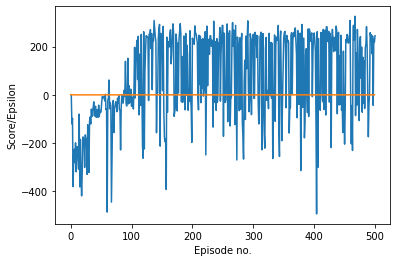

In [5]:
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
print(puntuacion)
plt.plot([i+1 for i in range(0,500,1)], puntuacion[:],eps_history)
plt.xlabel('Episode no.')
plt.ylabel('Score/Epsilon')
plt.show()

In [12]:
import pandas as pd
pf=pd.DataFrame.from_dict(puntuacion)
pf.head()
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/CS221/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
pf.to_csv (r'gdrive/My Drive/Colab Notebooks/CS221/DQN_LL.csv', index = True, header=True) # Path Example